In [1]:
import os

#add the root directory
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
from ANN_regression import *
import pickle
from datetime import datetime
from loader import *
import matplotlib.pyplot as plt
from PCAfold import log_transform

<h2> Train ANN for closure model of the a posteriori analysis

<h3> Prepare all the datasets

In [ ]:
Xu_H2O = "Xu"
Xu_optimized = "Xu"

In [ ]:
filename_autoignition = "isochoric-adiabatic-closed-HR-H2-air-lin_Z_0.015_0.035_100-T0_900-"
path_data_autoignition = "data-files/autoignition/" #autoignition/ in cluster
path_data = "data-files/"

#create all the datasets
mixture_fractions_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fraction.csv") #1 x nbr_timesteps
mixture_fractions_test = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}mixture-fractions-test-trajectories.csv") #1 x nbr_test_trajectories
state_space_names = np.genfromtxt(f"{path_data_autoignition}{filename_autoignition}state-space-names.csv", delimiter=",", dtype=str)
state_space_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space.csv", names = state_space_names)
state_space_source_train = pd.read_csv(f"{path_data_autoignition}{filename_autoignition}state-space-sources.csv", names = state_space_names)
time_train = np.loadtxt(f"{path_data_autoignition}{filename_autoignition}time.csv") #1 x nbr_timesteps

***
<h3> Create the dataset for the PV of Xu

In [ ]:
log_PVsource = True
log_transform = "log"
epsilon = 10**-5
print(epsilon)

onlyPos = True
scaleManifold = True

##########################################
########## Heuristic PV dataset ##########
##########################################

if(Xu_H2O == "Xu"):
    PV_Xu_train = state_space_train["H2O"] - state_space_train["H2"] - state_space_train["O2"]
elif(Xu_H2O == "H2O"):
    PV_Xu_train = state_space_train["H2O"]

PV_Xu_train = PV_Xu_train.to_numpy().reshape(-1,1)
PV_Xu_min_train = PV_Xu_train.min()
PV_Xu_max_train = PV_Xu_train.max()
PV_Xu_train_scaled = (PV_Xu_train - PV_Xu_min_train)/(PV_Xu_max_train - PV_Xu_min_train)

if(scaleManifold):
    df = pd.DataFrame({
        'PV Xu': PV_Xu_train.squeeze(),
        'mixture_fraction': mixture_fractions_train
    })

    # Normalize PV within each mixture_fraction group
    df['PV_Xu_scaled'] = df.groupby('mixture_fraction')['PV Xu'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0.0
    )

    # Get the PV back to numpy
    PV_Xu_train = df['PV_Xu_scaled'].to_numpy().reshape(-1, 1)

mixture_fractions_min_train = mixture_fractions_train.min()
mixture_fractions_max_train = mixture_fractions_train.max()
mixture_fractions_train_scaled = (mixture_fractions_train - mixture_fractions_min_train) / (mixture_fractions_max_train - mixture_fractions_min_train)

f_PV_Xu_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_Xu_train))
f_PV_Xu_train_scaled = np.hstack((mixture_fractions_train_scaled.reshape(-1,1), PV_Xu_train_scaled))

if(Xu_H2O == "Xu"):
    PV_Xu_source_train = state_space_source_train["H2O"] - state_space_source_train["H2"] - state_space_source_train["O2"]
elif(Xu_H2O == "H2O"):
    PV_Xu_source_train = state_space_source_train["H2O"]

PV_Xu_source_min_train = PV_Xu_source_train.min()
PV_Xu_source_max_train = PV_Xu_source_train.max()
PV_Xu_source_train_scaled = 2 * (PV_Xu_source_train - PV_Xu_source_min_train) / (PV_Xu_source_max_train - PV_Xu_source_min_train) - 1

PV_Xu_source_train = PV_Xu_source_train.to_numpy().reshape(-1,1)

if(onlyPos):
     mask_pos = PV_Xu_source_train>0
     f_PV_Xu_train = f_PV_Xu_train[mask_pos.squeeze(),:]
     PV_Xu_source_train = PV_Xu_source_train[mask_pos]

if(log_PVsource and Xu_optimized.lower() == "xu"):
    print(f"PV Xu source in log")
    #PV_Xu_source_train = np.log10(PV_Xu_source_train - PV_Xu_source_min_train + epsilon)
    if(log_transform == "continuous-symlog"):
         PV_Xu_source_train = log_transform(PV_Xu_source_train, method="continuous-symlog", threshold = epsilon)
    elif(log_transform == "log"):
         PV_Xu_source_train = np.log10(PV_Xu_source_train)
         PV_Xu_source_train = PV_Xu_source_train.reshape(-1, 1)
    else:
         raise ValueError("log-transformation not in the list")

     

##########################################
########## Optimized PV dataset ##########
##########################################

filename_model = "Xu-AE-opt_adam-epo_100000-lr_0.025-date_14Mar2025-hour_14h23_Tr0D-2q_s0"
filename_metadata = filename_model + "_metadata.pkl"
path_metadata = "metadata/"
filename_species_names = "Xu-state-space-names.csv"
path_data = "data-files/"

loader = loadData(filename_species_names, path_metadata, filename_metadata)
idx_species_removed = loader.metadata["list idx species removed source"] if loader.metadata["dataset_type"].startswith("autoignition_augm") else loader.metadata["idx species removed"]
id_model = loader.metadata["Training_id"]
model = loader.loadModel()

weight_inversion = True
if(weight_inversion):
    with torch.no_grad():  # Ensures we do not track gradients for this operation
        model.encoder_species.weight.mul_(-1)

state_space_names_DNS = np.genfromtxt(f"{path_data}Xu-state-space-names.csv", delimiter=",", dtype=str)

#create a np array in the format for the DNS dataset/optimized PV
state_space_train_DNS = state_space_train[state_space_names_DNS].to_numpy()
state_space_source_train_DNS = state_space_source_train[state_space_names_DNS].to_numpy()
print(state_space_source_train_DNS.shape)

PV_optimized_train = model.get_PV(torch.from_numpy(np.delete(state_space_train_DNS, idx_species_removed, axis=1))).detach().numpy()
PV_optimized_min_train = PV_optimized_train.min()
PV_optimized_max_train = PV_optimized_train.max()
PV_optimized_train_scaled = (PV_optimized_train - PV_optimized_min_train)/(PV_optimized_max_train - PV_optimized_min_train)

if(scaleManifold):
    df = pd.DataFrame({
        'PV optimized': PV_optimized_train.squeeze(),
        'mixture_fraction': mixture_fractions_train
    })

    # Normalize PV within each mixture_fraction group
    df['PV_optimized_scaled'] = df.groupby('mixture_fraction')['PV optimized'].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else 0.0
    )

    # Get the PV back to numpy
    PV_optimized_train = df['PV_optimized_scaled'].to_numpy().reshape(-1, 1)

f_PV_optimized_train = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train.reshape(-1,1)))
f_PV_optimized_train_scaled = np.hstack((mixture_fractions_train.reshape(-1,1), PV_optimized_train_scaled.reshape(-1,1)))
PV_optimized_source_train = model.get_PV(torch.from_numpy(np.delete(state_space_source_train_DNS, idx_species_removed, axis=1))).detach().numpy()
PV_optimized_source_train_min = PV_optimized_source_train.min()
PV_optimized_source_train_max = PV_optimized_source_train.max()

if(onlyPos):
     mask_pos = PV_optimized_source_train>0
     f_PV_optimized_train = f_PV_optimized_train[mask_pos.squeeze(),:]
     PV_optimized_source_train = PV_optimized_source_train[mask_pos]

if(log_PVsource and Xu_optimized.lower() == "optimized"):
        print("log PV optimized source")
        if(log_transform == "continuous-symlog"):
             PV_optimized_source_train = log_transform(PV_optimized_source_train, method="continuous-symlog", threshold = epsilon)
        elif(log_transform == "log"):
             PV_optimized_source_train = np.log10(PV_optimized_source_train)
             PV_optimized_source_train = PV_optimized_source_train.reshape(-1, 1)
        else:
         raise ValueError("log-transformation not in the list")

1e-05
PV Xu source in log
(241519, 21)


## Training of the encoder-decoder

In [6]:
max_epo = 5
my_seed = 7
std_weights = 0.05
learning_rate = 0.025
cosine_alpha = 0.01
cosine_decay_steps = max_epo
epo_show_loss = 1000
batch_size = len(mixture_fractions_train) #1000
perc_val = 0.1
nbr_input = 2
nbr_output = 1
neuron_layers = [5, 10, 10, 10]
loss = "MSE"


def cosine_decay(alpha, epo, tot_epo):
    """
    Cosine decay learning rate. Start at the initial learning rate and ends at initial learning rate times alpha.
    After tot_epo, the learning rate is constant and equal to initial learning rate times alpha.
    Alpha is the multiplier for the final learning rate.
    """

    myEpo = np.min([epo,tot_epo])

    return 0.5*(1-alpha)*(1+np.cos(np.pi*myEpo/tot_epo))+alpha

class LogMSELoss(nn.Module):
    def __init__(self, epsilon=1e-7):
        super(LogMSELoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        log_y_pred = torch.log(y_pred + self.epsilon + 1) #+1 to avoid negative values
        log_y_true = torch.log(y_true + self.epsilon + 1)
        loss = torch.mean((log_y_pred - log_y_true) ** 2)
        return loss
    
class RelativeErrorLoss(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(RelativeErrorLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        return torch.mean(torch.abs(y_true - y_pred) / (torch.abs(y_true) + self.epsilon))
    

###############################
#Initialization of the training
###############################

epo = 1
training_loss_list = np.zeros(max_epo)
validation_loss_list = np.zeros(max_epo)
best_validation_loss = np.inf
epo_best_model = 0


#############################
#Set seed for reproducibility
#############################

generator = torch.Generator()
generator.manual_seed(my_seed)

##################################################
#Split the data in training and validation dataset
#And scale the data and transform to torch tensors
##################################################

print(f"For data: {Xu_optimized}")

if(Xu_optimized == "Xu"):
    input_tensor = torch.tensor(f_PV_Xu_train)
    output_tensor = torch.tensor(PV_Xu_source_train)
elif(Xu_optimized == "Optimized"):
    input_tensor = torch.tensor(f_PV_optimized_train)
    output_tensor = torch.tensor(PV_optimized_source_train)

#determine number of training and validation samples
dataset_size = input_tensor.size(0)
train_size = int((1-perc_val) * dataset_size)

#shuffle the indices
indices = torch.randperm(dataset_size, generator=generator)

#split in training and validation indices
train_indices = indices[:train_size]
val_indices = indices[train_size:]

#create input and output tensors for both training and validation
train_input, val_input = input_tensor[train_indices], input_tensor[val_indices]
train_output, val_output = output_tensor[train_indices], output_tensor[val_indices]

#scale the input features between 0 and 1
mins_input = train_input[:, :].min(dim=0, keepdim=True)[0]
maxs_input = train_input[:, :].max(dim=0, keepdim=True)[0]
input_species_scaling = maxs_input - mins_input

#rescale the selected training inputs, rescale now between -0.5 and 0.5
train_input[:, :] = (train_input[:, :] - mins_input) / input_species_scaling - 0.5

#rescale the selected validation inputs
val_input[:, :] = (val_input[:, :] - mins_input) / input_species_scaling - 0.5


#rescale the output between -1 and 1
mins_output = train_output[:, :].min(dim=0, keepdim=True)[0]
maxs_output = train_output[:, :].max(dim=0, keepdim=True)[0]

#rescale the selected training outputs
train_output[:, :] = 2 * (train_output[:, :] - mins_output) / (maxs_output - mins_output) - 1

#rescale the selected validation outputs
val_output[:, :] = 2 * (val_output[:, :] - mins_output) / (maxs_output - mins_output) - 1


nbr_training_datapoints = train_input.size(0)

#####################
#Initialize the model
#####################

model = ANN_regression(nbr_input, nbr_output, neuron_layers)
model.initialize_model_weights(generator, std_weights)

model_params = {"nbr_input": nbr_input,
                "nbr_output": nbr_output,
                "neuron_layers": neuron_layers}

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
if(loss == "MSE"):
    loss_criterion = nn.MSELoss()
elif(loss == "logMSE"):
    loss_criterion = LogMSELoss()
elif(loss == "relError"):
    loss_criterion = RelativeErrorLoss()

scheduler = torch.optim.lr_scheduler.LambdaLR( #cosine decay learning rate scheduler
                optimizer, lr_lambda=lambda epoch: cosine_decay(cosine_alpha, epoch, cosine_decay_steps)
                )

For data: Xu


In [7]:
smallest_training_loss = np.inf
smallest_validation_loss = np.inf
best_model_state_dict = model.state_dict()
epo_best_model = -1

while(epo<=max_epo):
    #add criterion stop model
    
    training_loss = 0
    validation_loss = 0

    #Perform the minibatching
    torch.manual_seed(epo) #seed value is the epoch number
    indices = torch.randperm(nbr_training_datapoints) #shuffle the indices
    split_indices = torch.split(indices, batch_size) #split in subtensors for the batches
    
    #Start training
    for batch_idx in split_indices:

        output_model = model(train_input[batch_idx,:])
       
        #get MSE loss
        loss = loss_criterion(output_model, train_output[batch_idx,:])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += len(batch_idx)*loss.detach().cpu().numpy()

    #############
    #End training
    #############

    #################
    #Begin validation
    #################

    output_model = model(val_input)

    #get MSE loss
    loss = loss_criterion(output_model, val_output)

    validation_loss += loss.detach().cpu().numpy()
    ###############
    #End validation
    ###############
    
    #########################
    #Post-processing of epoch
    #########################

    #save training and validation loss
    training_loss_list[epo-1] = training_loss/nbr_training_datapoints #weighted average of all the training losses
    validation_loss_list[epo-1] = validation_loss
    
    epo += 1
    scheduler.step() #next learning rate in the scheduler

    if(epo%epo_show_loss==0):
        print(f"Current epoch: {epo} - Training loss (1e-05): {np.round(training_loss_list[epo-2]*100000,1)} - Validation loss (1e-05): {np.round(validation_loss_list[epo-2]*100000,1)}")
    
    if(validation_loss < smallest_validation_loss):
        smallest_training_loss = training_loss/nbr_training_datapoints
        smallest_validation_loss = validation_loss
        best_model_state_dict = model.state_dict()
        epo_best_model = epo

In [9]:
print(f"Best model: {epo_best_model} - Training loss (1e-06): {np.round(smallest_training_loss*1000000,1)} - Validation loss (1e-06): {np.round(smallest_validation_loss*1000000,1)}")

Best model: 6 - Training loss (1e-06): 290581.7 - Validation loss (1e-06): 283660.1


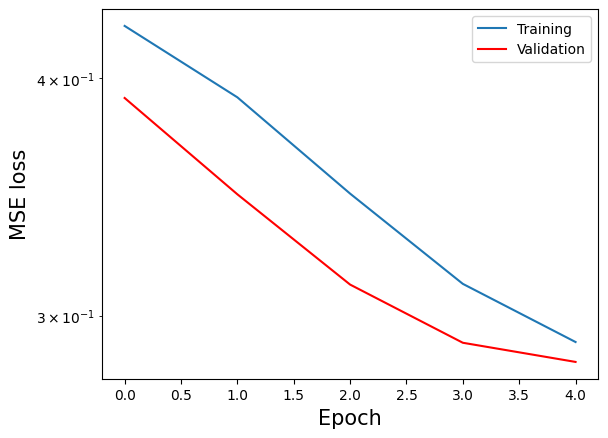

In [10]:
plt.plot(training_loss_list, label = "Training")
plt.plot(validation_loss_list, label = "Validation", color = "red")
plt.xlabel("Epoch", fontsize = 15)
plt.ylabel("MSE loss", fontsize = 15)
plt.yscale("log")
plt.legend()
plt.show()

In [11]:
#Save the data
metadata = {"data": Xu_optimized, "model_params": model_params, "autoignition data": filename_autoignition, "best training error": smallest_training_loss,
            "best validation error": smallest_validation_loss, "max_epo": max_epo, "best epo": epo_best_model,
            "my_seed": my_seed,
            "std_weights": std_weights,
            "learning_rate":learning_rate,
            "cosine_alpha": cosine_alpha,
            "cosine_decay_steps": cosine_decay_steps,
            "epo_show_loss": epo_show_loss,
            "batch_size": batch_size,
            "perc_val": perc_val,
            "nbr_input": nbr_input,
            "nbr_output": nbr_output,
            "neuron_layers": neuron_layers,
            "mins_input": mins_input,
            "maxs_input": maxs_input,
            "mins_output": mins_output,
            "maxs_output": maxs_output,
            "loss_criterion": loss,
            "filename_PV_model": filename_model,
            "weight_inversion": weight_inversion,
            "PV_Xu_source_min_train": PV_Xu_source_min_train,
            "log_PVsource": log_PVsource,
            "epsilon": epsilon,
            "Xu_H2O": Xu_H2O,
            "PV_optimized_source_train_min": PV_optimized_source_train_min,
            "PV_optimized_source_train_max": PV_optimized_source_train_max,
            "Only positive PV source": onlyPos,
            "log transformation": log_transform,
            "scaled manifold": scaleManifold}

now = datetime.now()
date_str = now.strftime("%Y-%m-%d")
time_str = now.strftime("%Hh%M")

if(Xu_H2O == "H2O" and Xu_optimized == "Xu"):
    with open(f'autoignition/models/H2O_{date_str}_{time_str}_metadata.pkl', 'wb') as f:
        pickle.dump(metadata, f)
elif(Xu_optimized == "Xu"):
    with open(f'autoignition/models/Xu_{date_str}_{time_str}_metadata.pkl', 'wb') as f:
        pickle.dump(metadata, f)  
elif(Xu_optimized == "Optimized"):
    with open(f'autoignition/models/Optimized_{id_model}_{date_str}_{time_str}_metadata.pkl', 'wb') as f:
                pickle.dump(metadata, f)

In [12]:
if(Xu_H2O == "H2O" and Xu_optimized == "Xu"):
    torch.save(best_model_state_dict, '{}{}'.format("autoignition/models/", f'H2O_{date_str}_{time_str}_model.pth'))
    print(f'H2O_{date_str}_{time_str}_model.pth')
elif(Xu_optimized == "Xu"):
    torch.save(best_model_state_dict, '{}{}'.format("autoignition/models/", f'Xu_{date_str}_{time_str}_model.pth'))
    print(f'Xu_{date_str}_{time_str}_model.pth')
elif(Xu_optimized == "Optimized"):
    torch.save(best_model_state_dict, '{}{}'.format("autoignition/models/", f'Optimized_{id_model}_{date_str}_{time_str}_model.pth'))
    print(f'Optimized_{id_model}_{date_str}_{time_str}_model.pth')

Xu_2025-07-10_15h08_model.pth
